In [6]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras_tqdm import TQDMCallback, TQDMNotebookCallback
import gdax
from time import sleep


from math import sqrt
from matplotlib import pyplot
import numpy

def get_loads(symbol, start=None, end=None, granularity=86400):
    """ This was fiddly so I'm not live-coding this one"""
    public_client = gdax.PublicClient()
    if end is None:
        end = pd.to_datetime('now')
    if start is None:
        start = end-pd.Timedelta(seconds=granularity)
        
    while True:
        response = public_client.get_product_historic_rates(
                product_id=symbol,
                granularity=granularity,
                start=start.isoformat(),
                end=end.isoformat()
            )
        
        if not response:
            raise StopIteration()
        if not isinstance(response,list):
            raise ValueError(response)
            
        for r in response:
            yield r
        sleep(3)
        end = pd.to_datetime(r[0], unit='s')
        start = end-pd.Timedelta(seconds=granularity*len(response))
        print(f"{start}-{end}")
        
def get_data():
    df = pd.DataFrame(
    get_loads('BTC-USD'),
        columns=['time','low','high','open','close','volume']
    )
    df['time'] = pd.to_datetime(df['time'], unit='s')
    return df.set_index('time')['close']
    

# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False,
                 callbacks=[TQDMNotebookCallback(leave_inner=False,leave_outer=False)])
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

# load dataset
#series = read_csv(source_file, header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
series = get_data()

split = series.shape[0]//3

# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-split], supervised_values[-split:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))



2016-09-01 00:00:00-2017-06-28 00:00:00
2015-11-06 00:00:00-2016-09-01 00:00:00
2015-01-10 00:00:00-2015-11-06 00:00:00
2014-03-23 00:00:00-2015-01-13 00:00:00
2014-11-21 00:00:00-2014-12-01 00:00:00


Month=1, Predicted=377.559665, Expected=372.680000
Month=2, Predicted=371.928882, Expected=371.140000
Month=3, Predicted=370.277422, Expected=377.490000
Month=4, Predicted=376.357375, Expected=375.440000
Month=5, Predicted=374.429655, Expected=384.500000
Month=6, Predicted=383.113063, Expected=387.990000
Month=7, Predicted=386.625736, Expected=368.870000
Month=8, Predicted=368.129425, Expected=372.930000
Month=9, Predicted=371.711640, Expected=371.330000
Month=10, Predicted=370.246921, Expected=367.950000
Month=11, Predicted=366.893795, Expected=378.460000
Month=12, Predicted=376.992759, Expected=378.680000
Month=13, Predicted=377.367105, Expected=379.610000
Month=14, Predicted=378.232695, Expected=394.790000
Month=15, Predicted=392.949456, Expected=391.540000
Month=16, Predicted=390.061858, Expected=391.400000
Month=17, Predicted=389.853643, Expected=403.050000
Month=18, Predicted=401.167283, Expected=387.500000
Month=19, Predicted=386.326390, Expected=382.900000
Month=20, Predicted=3

Month=166, Predicted=229.241336, Expected=231.550000
Month=167, Predicted=230.170079, Expected=225.800000
Month=168, Predicted=224.608553, Expected=226.810000
Month=169, Predicted=225.480497, Expected=223.730000
Month=170, Predicted=222.518497, Expected=211.160000
Month=171, Predicted=210.274631, Expected=229.210000
Month=172, Predicted=227.529392, Expected=231.150000
Month=173, Predicted=229.722277, Expected=232.850000
Month=174, Predicted=231.348036, Expected=235.560000
Month=175, Predicted=234.013207, Expected=227.340000
Month=176, Predicted=226.103367, Expected=221.990000
Month=177, Predicted=220.782936, Expected=257.310000
Month=178, Predicted=254.917114, Expected=259.200000
Month=179, Predicted=257.361161, Expected=262.460000
Month=180, Predicted=260.508195, Expected=266.170000
Month=181, Predicted=264.224497, Expected=264.670000
Month=182, Predicted=262.879360, Expected=266.940000
Month=183, Predicted=265.097316, Expected=271.990000
Month=184, Predicted=270.078070, Expected=265.

Month=343, Predicted=275.433902, Expected=273.370000
Month=344, Predicted=272.119018, Expected=283.270000
Month=345, Predicted=281.629822, Expected=276.700000
Month=346, Predicted=275.444460, Expected=260.240000
Month=347, Predicted=259.368940, Expected=255.590000
Month=348, Predicted=254.594480, Expected=254.420000
Month=349, Predicted=253.386586, Expected=237.110000
Month=350, Predicted=236.566977, Expected=238.190000
Month=351, Predicted=237.270385, Expected=239.870000
Month=352, Predicted=238.899728, Expected=239.490000
Month=353, Predicted=238.492815, Expected=236.830000
Month=354, Predicted=235.860917, Expected=245.990000
Month=355, Predicted=244.645713, Expected=245.340000
Month=356, Predicted=244.143519, Expected=240.900000
Month=357, Predicted=239.785727, Expected=237.490000
Month=358, Predicted=236.393643, Expected=244.820000
Month=359, Predicted=243.419507, Expected=234.680000
Month=360, Predicted=233.708381, Expected=235.540000
Month=361, Predicted=234.329012, Expected=256.

ValueError: Found input variables with inconsistent numbers of samples: [12, 402]

Test RMSE: 13.408


<IPython.core.display.Javascript object>


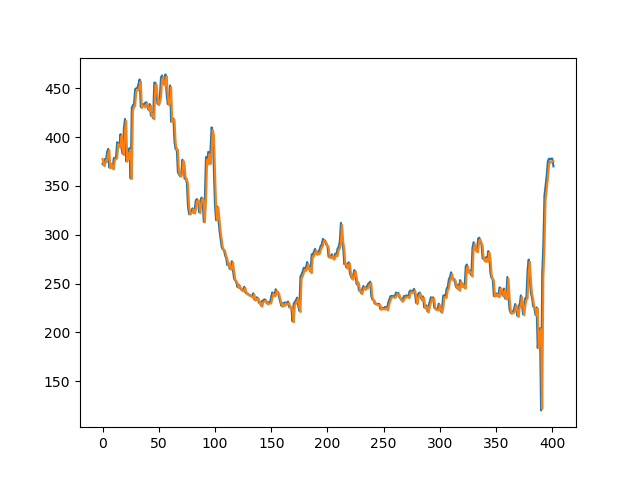

In [10]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[-split:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
%matplotlib nbagg
pyplot.plot(raw_values[-split:])
pyplot.plot(predictions)
pyplot.show()

In [11]:
lstm_model.save('lstm_1_3000_4.h5')